In [9]:
import numpy as np
import pandas as pd
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy.cluster.hierarchy import linkage, fcluster
import yfinance as yf
import time
import glob
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

In [56]:
import qlib
from qlib.data import D
from qlib.constant import REG_US

# Set up Qlib data directory and initialize it
qlib_data_path = os.path.expanduser("C:/Users/ns99a/.qlib/qlib_data/us_data")

# Initialize Qlib
qlib.init(provider_uri=qlib_data_path, region=REG_US)

# Fetch instruments from NASDAQ-100
nasdaq100_config = D.instruments(market="nasdaq100")

# Extract the list of stock symbols
nasdaq100_stocks = D.list_instruments(instruments=nasdaq100_config, as_list=True)

print(f"Total NASDAQ-100 stocks: {len(nasdaq100_stocks)}")
print("First 10 NASDAQ-100 stocks:", nasdaq100_stocks[:10])

# Fetch data for a specific stock
stock_symbol = "AAPL"
fields = ["$open", "$high", "$low", "$close", "$volume", "$adj_close"]
data = D.features([stock_symbol], fields, start_time="2010-01-01", end_time="2026-12-21", freq="day")

print(data.head())

[23476:MainThread](2025-03-06 12:19:37,881) INFO - qlib.Initialization - [config.py:420] - default_conf: client.
[23476:MainThread](2025-03-06 12:19:37,888) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[23476:MainThread](2025-03-06 12:19:37,890) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/ns99a/.qlib/qlib_data/us_data')}


Total NASDAQ-100 stocks: 283
First 10 NASDAQ-100 stocks: ['ATVI', 'ADBE', 'AMD', 'ALXN', 'ALGN', 'GOOGL', 'GOOG', 'AMZN', 'AMGN', 'ADI']
                          $open     $high      $low    $close      $volume  \
instrument datetime                                                          
AAPL       2010-01-04  8.303659  8.345288  8.262809  8.326224  453228352.0   
           2010-01-05  8.349177  8.387694  8.296655  8.340618  552529920.0   
           2010-01-06  8.340620  8.373691  8.199392  8.207952  506865600.0   
           2010-01-07  8.238297  8.248025  8.133252  8.192778  437991520.0   
           2010-01-08  8.181883  8.248023  8.133640  8.247245  410892800.0   

                       $adj_close  
instrument datetime                
AAPL       2010-01-04         NaN  
           2010-01-05         NaN  
           2010-01-06         NaN  
           2010-01-07         NaN  
           2010-01-08         NaN  


In [41]:
import pandas as pd

csv_directory = f"./data/stocks/datasets/dj30/raw/"

if not os.path.exists(csv_directory):
    os.makedirs(csv_directory)

# Save the extracted data into a CSV file
csv_filename = f"./data/stocks/datasets/dj30/raw/{stock_symbol}.csv"
data.to_csv(csv_filename)
print(f"Saved {stock_symbol} data to {csv_filename}")

Saved AAPL data to ./data/stocks/datasets/dj30/raw/AAPL.csv


In [51]:
# now I want to iterate overa ll the stocks
fields = ["$open", "$high", "$low", "$close", "$volume"]

for stock in nasdaq100_stocks:
    stock_symbol = stock
    data = D.features([stock_symbol], fields, start_time="2010-01-01", end_time="2026-12-21", freq="day").reset_index()

    # Save the extracted data into a CSV file
    csv_filename = f"./data/stocks/datasets/dj30/raw/{stock_symbol}.csv"
    data.to_csv(csv_filename)
    print(f"Saved {stock_symbol} data to {csv_filename}")


Saved ATVI data to ./data/stocks/datasets/dj30/raw/ATVI.csv
Saved ADBE data to ./data/stocks/datasets/dj30/raw/ADBE.csv
Saved AMD data to ./data/stocks/datasets/dj30/raw/AMD.csv
Saved ALXN data to ./data/stocks/datasets/dj30/raw/ALXN.csv
Saved ALGN data to ./data/stocks/datasets/dj30/raw/ALGN.csv
Saved GOOGL data to ./data/stocks/datasets/dj30/raw/GOOGL.csv
Saved GOOG data to ./data/stocks/datasets/dj30/raw/GOOG.csv
Saved AMZN data to ./data/stocks/datasets/dj30/raw/AMZN.csv
Saved AMGN data to ./data/stocks/datasets/dj30/raw/AMGN.csv
Saved ADI data to ./data/stocks/datasets/dj30/raw/ADI.csv
Saved ANSS data to ./data/stocks/datasets/dj30/raw/ANSS.csv
Saved AAPL data to ./data/stocks/datasets/dj30/raw/AAPL.csv
Saved AMAT data to ./data/stocks/datasets/dj30/raw/AMAT.csv
Saved ASML data to ./data/stocks/datasets/dj30/raw/ASML.csv
Saved ADSK data to ./data/stocks/datasets/dj30/raw/ADSK.csv
Saved ADP data to ./data/stocks/datasets/dj30/raw/ADP.csv
Saved BIDU data to ./data/stocks/datasets/dj

# DATA

In [59]:
# path to folder containing csv files. Each files correspond to an asset (stock)
folder_path = os.path.join("data", "stocks", "datasets","dj30","raw", "*.csv")
csv_files = glob.glob(folder_path)
data_frames = []

for file in csv_files:
    # each file name is the stock symbol, so we simply extract sticker from the file's name
    symbol = os.path.splitext(os.path.basename(file))[0]
    print(f"processing {symbol} from {file}...")
    
    # parse "Date" column and filter the desired timeline (range). To be updated later !!!(problem with yahoo"s API)
    df = pd.read_csv(file, parse_dates=['Date'])
    #df = df.loc[~df.index.duplicated(keep='first')]
    mask = (df['Date'] >= '2010-01-01') & (df['Date'] <= '2018-12-21')
    df = df.loc[mask]
    # we only consider "Date" and "Adj Close" columns
    df = df[['Date', 'Adj Close']].set_index('Date')
    df.rename(columns={'Adj Close': symbol}, inplace=True)
    data_frames.append(df)

merged_df = pd.concat(data_frames, axis=1)
merged_df.sort_index(inplace=True)
print(merged_df.head())
#uncomment the next line to save the csv containing all stocks daily prices
#merged_df.to_csv("merged_historical_prices.csv")

processing AAPL from data\stocks\datasets\dj30\raw\AAPL.csv...
processing AMGN from data\stocks\datasets\dj30\raw\AMGN.csv...
processing AXP from data\stocks\datasets\dj30\raw\AXP.csv...
processing BA from data\stocks\datasets\dj30\raw\BA.csv...
processing CAT from data\stocks\datasets\dj30\raw\CAT.csv...
processing CRM from data\stocks\datasets\dj30\raw\CRM.csv...
processing CSCO from data\stocks\datasets\dj30\raw\CSCO.csv...
processing CVX from data\stocks\datasets\dj30\raw\CVX.csv...
processing DIS from data\stocks\datasets\dj30\raw\DIS.csv...
processing GS from data\stocks\datasets\dj30\raw\GS.csv...
processing HD from data\stocks\datasets\dj30\raw\HD.csv...
processing HON from data\stocks\datasets\dj30\raw\HON.csv...
processing IBM from data\stocks\datasets\dj30\raw\IBM.csv...
processing INTC from data\stocks\datasets\dj30\raw\INTC.csv...
processing JNJ from data\stocks\datasets\dj30\raw\JNJ.csv...
processing JPM from data\stocks\datasets\dj30\raw\JPM.csv...
processing KO from dat

In [ ]:
#### You can ignore this part, i used SP500 for regime switching model but it didn't work for a univariate RSM
#### Will consider a multivariate RSM later (probably for the final version)

"""DON'T RUN THIS PART !!!!!
"""
path = os.path.join("stocks", "datasets","dj30", 'SP500.csv')
sp500_df = pd.read_csv(path, parse_dates=['Date'])
#sp500_df['Date'] = pd.to_datetime(sp500_df['Date'], format='%m/%d/%Y')
sp500_df['Date'] = pd.to_datetime(sp500_df['Date'], infer_datetime_format=True, errors='coerce')
sp500_df.dropna(subset=['Date'], inplace=True)
mask = (sp500_df['Date'] >= '2010-01-01') & (sp500_df['Date'] <= '2022-01-01')
sp500_df = sp500_df.loc[mask]
sp500_prices = sp500_df[['Date', 'Close']].copy()
sp500_prices.rename(columns={'Close': 'SP500'}, inplace=True)
sp500_prices.set_index('Date', inplace=True)
df = merged_df
df = df.merge(sp500_prices, left_index=True, right_index=True, how='outer')
df.sort_index(inplace=True)
df.fillna(method='ffill', inplace=True)
columns, shape = df.columns, df.shape
print(columns,shape)

# Correlation clustering

In [60]:
# non overlapping windows to compute correlation matrices
log_returns = np.log(merged_df / merged_df.shift(1)).dropna()
window_size = 120
correlation_matrices = []
for start in range(0, len(log_returns) - window_size + 1, window_size):
    window_data = log_returns.iloc[start:start+window_size]
    corr_matrix = window_data.corr().values
    correlation_matrices.append(corr_matrix)
    
# we vectorize the upper triangular part
n_assets = log_returns.shape[1]
features = [mat[np.triu_indices(n_assets, k=1)] for mat in correlation_matrices]
features = np.array(features)

# Ward's method for hierarchical clustering
Z = linkage(features, method='ward')
n_clusters = 3
clusters = fcluster(Z, t=n_clusters, criterion='maxclust')

# representative corr matrix for each cluster
rep_corr_matrices = []
for cluster_id in range(1, n_clusters + 1):
    indices = np.where(clusters == cluster_id)[0]
    avg_corr = np.mean([correlation_matrices[i] for i in indices], axis=0)
    rep_corr_matrices.append(avg_corr)

print("\nrepresentative correlation matrices:")
for i, mat in enumerate(rep_corr_matrices):
    print(f"Matrix {i+1}:\n", mat)


representative correlation matrices:
Matrix 1:
 [[1.         0.45358289 0.55375847 0.57820595 0.62287022 0.47481722
  0.56046428 0.56750093 0.51682564 0.47325976 0.53492178 0.6555416
  0.62186917 0.587193   0.54974003 0.52243326 0.48167609 0.50283316
  0.5940191  0.46497148 0.6051014  0.5945071  0.48886557 0.49253768
  0.45253194 0.5004553  0.49586821 0.39306539 0.39155385]
 [0.45358289 1.         0.50779818 0.53467584 0.46813724 0.35638594
  0.45169556 0.52985611 0.52353505 0.4519705  0.53297998 0.57659726
  0.5442963  0.50893065 0.61685778 0.49667955 0.51979065 0.53951849
  0.54008079 0.56819345 0.51101929 0.52016961 0.50636854 0.53915672
  0.54886007 0.41905059 0.52150004 0.43283642 0.44129624]
 [0.55375847 0.50779818 1.         0.66052892 0.66716411 0.49465403
  0.58374095 0.6309413  0.6297097  0.61168212 0.64166934 0.70733955
  0.61982806 0.5887532  0.58034622 0.71778775 0.56863845 0.56762624
  0.6763757  0.57997142 0.61404982 0.63609646 0.53497213 0.62947342
  0.49501252 0.57302

# Monte Carlo Simulation

In [61]:
annual_factor = 252  # trading days per year
annual_drift = log_returns.mean() * annual_factor # drift (return) for each asset
annual_vol = log_returns.std() * np.sqrt(annual_factor)  # volatility for each asset
mu = annual_drift.values    
sigmas = annual_vol.values   

# for starting prices, we use the last available prices from our original df
S0s = merged_df.iloc[-1].values

# pre-simulation config
T = 1       # 1 year
dt = 1 / 252  # daily step
n_steps = int(T / dt)

def simulate_correlated_prices(S0s, mu, sigmas, T, dt, corr_matrix):
    """
    single price trajectory using the Black-Scholes-Merton model
    """
    n_assets = len(S0s)
    n_steps = int(T / dt)
    prices = np.zeros((n_steps + 1, n_assets))
    prices[0] = S0s
    L = np.linalg.cholesky(corr_matrix)  # we use cholesky for correlated noise
    for t in range(1, n_steps + 1):
        Z = np.random.normal(0, 1, size=n_assets)
        correlated_Z = L @ Z
        prices[t] = prices[t-1] * np.exp((mu - 0.5 * sigmas**2) * dt + sigmas * np.sqrt(dt) * correlated_Z)
    return prices

def simulate_multiple_paths(S0s, mu, sigmas, T, dt, corr_matrix, num_paths=100):
    """
    here, we generate multiple simulation paths for a given correlation matrix
    """
    sims = []
    for _ in range(num_paths):
        sim = simulate_correlated_prices(S0s, mu, sigmas, T, dt, corr_matrix)
        sims.append(sim)
    return np.array(sims)

# generate multiple simulation trajectories for each representative correlation matrix, 
all_simulations = {}
num_paths = 1000  # 1000 trajectories per rep matrix
for idx, corr in enumerate(rep_corr_matrices):
    sims = simulate_multiple_paths(S0s, mu, sigmas, T, dt, corr, num_paths=num_paths)
    all_simulations[idx] = sims
    print(f"representative Matrix {idx+1}: {sims.shape[0]} trajectories generated")

# we combine all simulations
combined_simulations = np.concatenate(list(all_simulations.values()), axis=0)
print("combined simulation trajectories shape:", combined_simulations.shape)

representative Matrix 1: 1000 trajectories generated
representative Matrix 2: 1000 trajectories generated
representative Matrix 3: 1000 trajectories generated
combined simulation trajectories shape: (3000, 253, 29)


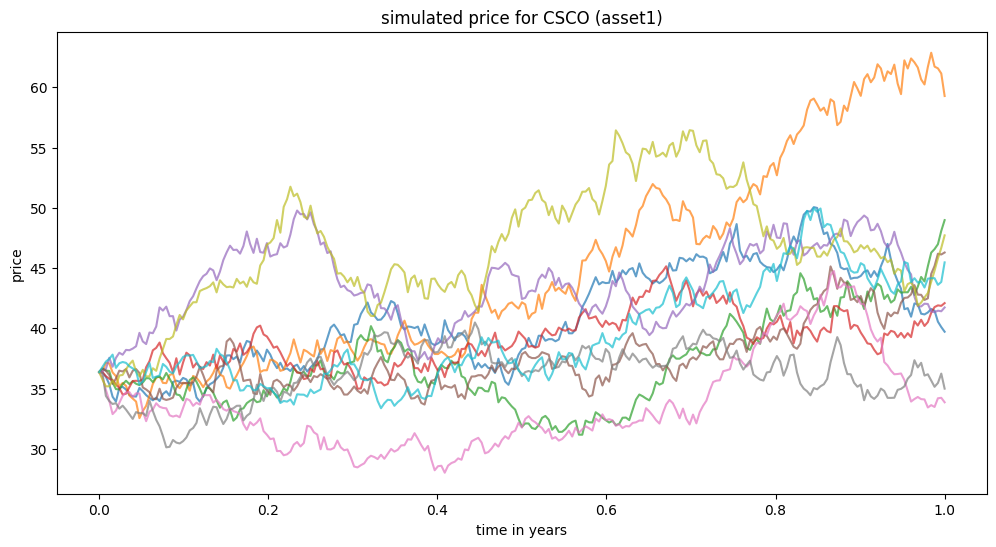

: 

In [ ]:
# for plot, we consider the first asset
asset_index = 0
# we randomly select 10 simulations
num_to_plot = 10
total_paths = combined_simulations.shape[0]
sample_indices = np.random.choice(total_paths, size=num_to_plot, replace=False)
# time vector
n_steps_plus_1 = combined_simulations.shape[1]
time = np.linspace(0, 1, n_steps_plus_1)  # time in years
plt.figure(figsize=(12, 6))
for idx in sample_indices:
    plt.plot(time, combined_simulations[idx, :, asset_index], alpha=0.7)

plt.title(f"simulated price for CSCO (asset1)")
plt.xlabel("time in years")
plt.ylabel("price")
plt.show()